In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import attila_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Motivation

Reviewer 1 asked about the relationship between lipid sidechain length and lipid level in ChAc w.r.t Control:

> Lipidomic studies have shown that lipid chains can also be affected in the context of PD in post-mortem tissues and human fibroblasts (Abbott SK, et al Mov Disord 2014; Galvagnion et al, Brain, 2022). Are there any significant changes in the distribution of chains among the different sphingolipids and phospholipids in ChAc samples?

There is an ambiguity in determining this relationship because for a few lipid groups more than one side chains can vary in their lenght.

In [2]:
lipid_group_dict = pd.read_csv('../../resources/lipid-group-dictionary.csv', index_col='abbreviation')
stddata = pd.read_csv('../../results/2022-09-04-mixed-models/long-stddata.csv', index_col=list(range(4)))
stddata = stddata.rename(dict(zip(stddata.columns, [s.replace('.1', '') for s in stddata.columns])), axis=1)
stddata = stddata.rename_axis([s.lower() for s in stddata.index.names], axis=0)
stddata

Level Group     Species   Region  \
group species    region  subject                                          
FC    FC         CN      ChAc 1    -0.520661    FC          FC       CN   
                         ChAc 2    -2.466412    FC          FC       CN   
                         ChAc 3     1.146440    FC          FC       CN   
                         ChAc 4     1.268065    FC          FC       CN   
                         Control 1  1.302206    FC          FC       CN   
...                                      ...   ...         ...      ...   
NSer  NSer 22:6  Putamen Control 2 -0.464183  NSer  NSer 22:6   Putamen   
                         Control 3  0.914578  NSer  NSer 22:6   Putamen   
                         Control 4 -0.905387  NSer  NSer 22:6   Putamen   
                         Control 5 -0.188431  NSer  NSer 22:6   Putamen   
                         Control 6  0.032171  NSer  NSer 22:6   Putamen   

                                      Subject       Region:Subject       Dx  \
group species    region  subject                                              
FC    FC         CN      ChAc 1        ChAc 1          CN : ChAc 1     ChAc   
                         ChAc 2        ChAc 2          CN : ChAc 2     ChAc   
                         ChAc 3        ChAc 3          CN : ChAc 3     ChAc   
                         ChAc 4        ChAc 4          CN : ChAc 4     ChAc   
                         Control 1  Control 1       CN : Control 1  Control   
...                                       ...                  ...      ...   
NSer  NSer 22:6  Putamen Control 2  Control 2  Putamen : Control 2  Control   
                         Control 3  Control 3  Putamen : Control 3  Control   
                         Control 4  Control 4  Putamen : Control 4  Control   
                         Control 5  Control 5  Putamen : Control 5  Control   
                         Control 6  Control 6  Putamen : Control 6  Control   

                                    AgeAtDeath   PMI  
group species    region  subject                      
FC    FC         CN      ChAc 1             51   8.0  
                         ChAc 2             50  32.7  
                         ChAc 3             61  12.8  
                         ChAc 4             40  22.0  
                         Control 1          53  25.4  
...                                        ...   ...  
NSer  NSer 22:6  Putamen Control 2          50  23.3  
                         Control 3          57  26.4  
                         Control 4          59  33.0  
                         Control 5          54  19.3  
                         Control 6          59  31.3  

[17670 rows x 9 columns]

In [3]:
def get_sidechain2(group, regex, data=stddata):
    groupdata = data.xs(group, axis=0, level='group').copy()
    s = groupdata['Species']
    groupdata.loc[:, 'Sidechain length'] = s.apply(lambda x: np.int64(re.sub(regex, '\\1', x)))
    groupdata.loc[:, 'Deg. unsaturation'] = s.apply(lambda x: np.int64(re.sub(regex, '\\2', x)))
    return(groupdata)

def get_sidechain3(group, regex, data=stddata):
    groupdata = data.xs(group, axis=0, level='group').copy()
    s = groupdata['Species']
    groupdata.loc[:, 'Deg. unsat. ch.1'] = s.apply(lambda x: np.int64(re.sub(regex, '\\1', x)))
    groupdata.loc[:, 'Sidechain length'] = s.apply(lambda x: np.int64(re.sub(regex, '\\2', x)))
    groupdata.loc[:, 'Deg. unsat. ch.2'] = s.apply(lambda x: np.int64(re.sub(regex, '\\3', x)))
    return(groupdata)

def plot_level_sidechain_dunsat(group, regex, data=stddata, fun=get_sidechain2):
    groupdata = fun(group, regex, data=stddata)
    if 'Deg. unsaturation' in groupdata.columns:
        degs = groupdata['Deg. unsaturation'].unique()
    else:
        degs = groupdata.apply(lambda s: (s.loc['Deg. unsat. ch.1'], s.loc['Deg. unsat. ch.2']), axis=1).unique()
    fig, ax = plt.subplots(len(degs), 3, sharex=True, sharey=True, figsize=(6, 1 * len(degs)))
    group_by = 'Deg. unsaturation' if 'Deg. unsaturation' in groupdata.columns else ['Deg. unsat. ch.1', 'Deg. unsat. ch.2']
    for axi, name_group in zip(ax, groupdata.groupby(group_by)):
        name, df = name_group
        for axii, region in zip(axi, ['CN', 'Putamen', 'DLPFC']):
            label = 'Control' if axii == ax[0, 0] else None
            sns.regplot(x='Sidechain length', y='Level', data=df.loc[(df.Dx == 'Control') & (df.Region == region)], order=1, ax=axii, marker='+', label=label)
            label = 'ChAc' if axii == ax[0, 0] else None
            sns.regplot(x='Sidechain length', y='Level', data=df.loc[(df.Dx == 'ChAc') & (df.Region == region)], order=1, ax=axii, marker='+', label=label)
            axii.set_xlabel('')
            axii.set_ylabel(name if region == 'CN' else '')
            axii.set_ylabel('du=' + str(name) if region == 'CN' else '')
            axii.set_title(region if name == degs[0] else '')
    fig.supxlabel('Sidechain length', y=-0.02)
    fig.supylabel('Lipid level', x=-0.02)
    fig.suptitle('Lipid group: ' + group, y=1.02)
    fig.legend()
    return((fig, ax))

#fig, ax = plot_level_sidechain_dunsat('PCe', 'PCe ([0-9]{2}):([0-9]{1,2})$')
#fig, ax = plot_level_sidechain_dunsat('Sulf', 'Sulf d18:([0-9]{1})/([0-9]{2}):([0-9]{1})$', fun=get_sidechain3)

In [4]:
def get_sidechain(group, regex, data=stddata):
    groupdata = data.xs(group, axis=0, level='group').copy()
    s = groupdata['Species']
    groupdata.loc[:, 'Sidechain length'] = s.apply(lambda x: np.int64(re.sub(regex, '\\1', x)))
    return(groupdata)

def plot_level_sidechain_region(region, groupdata, axes, Dx2title=False, ylabel='region'):
    df = groupdata.xs(region, axis=0, level='region')
    for axi, Dx in zip(axes, ['Control', 'ChAc']):
        sns.regplot(x='Sidechain length', y='Level', data=df.loc[df.Dx == Dx], order=2, ax=axi, marker='+')
        axi.set_xlabel('')
        axi.set_ylabel('')
        if Dx2title:
            axi.set_title(Dx)
        if ylabel == 'region' and Dx == 'Control':
            axi.set_ylabel(region)
    return(axes)

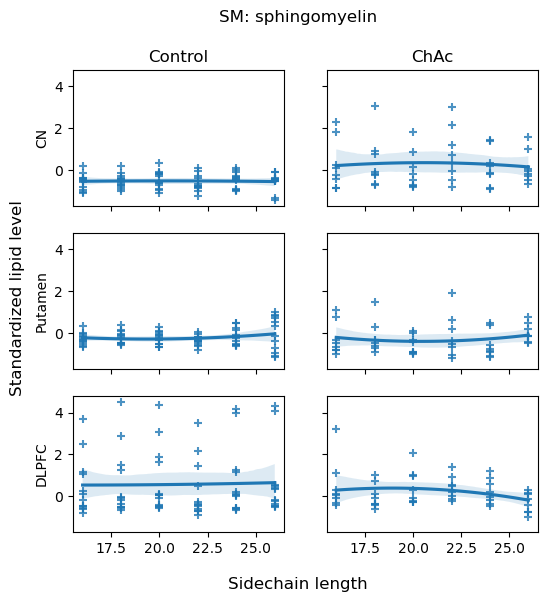

In [5]:
def plot_level_sidechain(group='SM', regex='SM d18:1/([0-9]{2}):.*$', data=stddata, lipid_group_dict=lipid_group_dict):
    fig, ax = plt.subplots(3, 2, sharey=True, sharex=True, figsize=(6, 6))
    regions = ['CN', 'Putamen', 'DLPFC']
    groupdata = get_sidechain(group, regex)
    for i, var in enumerate(zip(regions, ax)):
        region, axi = var
        axi = plot_level_sidechain_region(region, groupdata, axi, i == 0)
    fig.suptitle(group + ': ' + lipid_group_dict.loc[group].to_list()[0])
    fig.supxlabel('Sidechain length')
    fig.supylabel('Standardized lipid level')
    return((fig, ax))

fig, ax = plot_level_sidechain('SM', 'SM d18:1/([0-9]{2}):.*$')

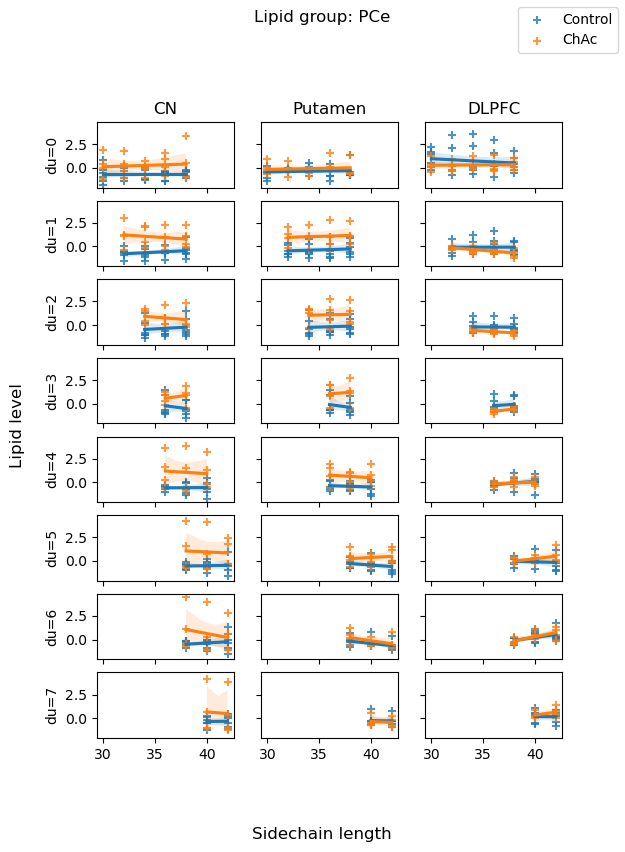

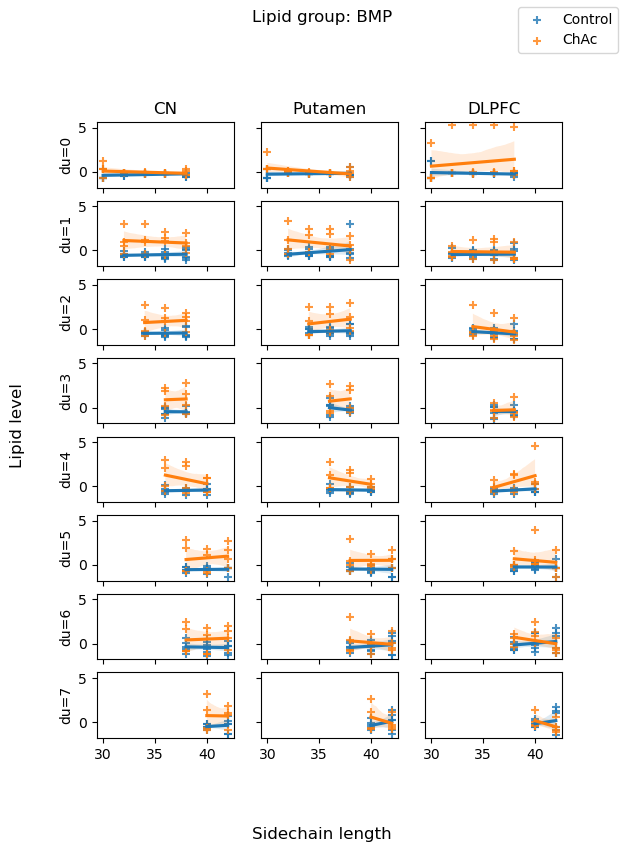

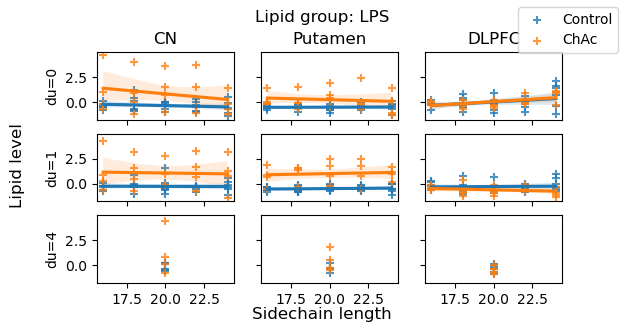

In [6]:
regexd2 = {
    'PCe': 'PCe ([0-9]{2}):([0-9]{1,2})$',
    'BMP': 'BMP ([0-9]{2}):([0-9]{1,2})$',
    'LPS': 'LPS ([0-9]{2}):([0-9]{1,2})$',
         }

for group, regex in regexd2.items():
    fig, ax = plot_level_sidechain_dunsat(group, regex)
    attila_utils.savefig(fig, 'level-1_sidechain_len-' + group)

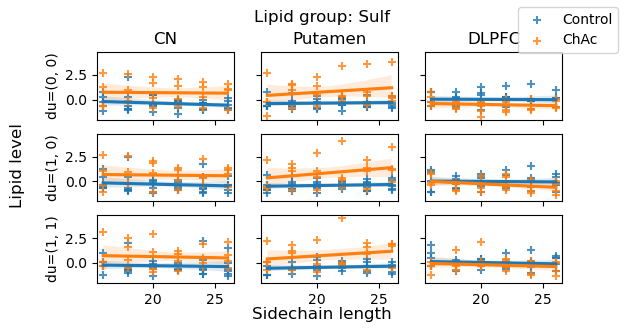

In [7]:
regexd3 = {
    'Sulf': 'Sulf d18:([0-9]{1})/([0-9]{2}):([0-9]{1})$',
         }

for group, regex in regexd3.items():
    fig, ax = plot_level_sidechain_dunsat(group, regex, fun=get_sidechain3)
    attila_utils.savefig(fig, 'level-2_sidechain_len-' + group)

In [8]:
regexd = {
    'CE': 'CE ([0-9]{2}):.*$',
    'AC': 'AC C([0-9]{1,2}):.*$',
    'MG': 'MG ([0-9]{2}):.*$',
    'DG': 'DG ([0-9]{2}):.*$',
    'TG': 'TG ([0-9]{2}):.*$',
    'dhCer': 'dhCer d18:./([0-9]{2}):.*$',
    'Cer': 'Cer d18:./([0-9]{2}):.*$',
    'SM': 'SM d18:1/([0-9]{2}):.*$',
    'dhSM': 'dhSM d18:./([0-9]{2}):.*$',
    'MhCer': 'MhCer d18:./([0-9]{2}):.*$',
    'Sulf': 'Sulf d18:./([0-9]{2}):.*$',
    'LacCer': 'LacCer d18:./([0-9]{2}):.*$',
    'GM3': 'GM3 d18:./([0-9]{2}):.*$',
    'GB3': 'GB3 d18:./([0-9]{2}):.*$',
    'PA': 'PA ([0-9]{2}):.*$',
    'PC': 'PC ([0-9]{2}):.*$',
    'PCe': 'PCe ([0-9]{2}):.*$',
    'PE': 'PE ([0-9]{2}):.*$',
    'PEp': 'PEp ([0-9]{2}):.*$',
    'PS': 'PS ([0-9]{2}):.*$',
    'PI': 'PI ([0-9]{2}):.*$',
    'PG': 'PG ([0-9]{2}):.*$',
    'BMP': 'BMP ([0-9]{2}):.*$',
    'AcylPG': 'AcylPG 16:.-([0-9]{2}):.*$',
    'LPC': 'LPC ([0-9]{2}):.*$',
    'LPCe': 'LPCe ([0-9]{2}):.*$',
    'LPE': 'LPE ([0-9]{2}):.*$',
    'LPEp': 'LPEp ([0-9]{2}):.*$',
    'LPI': 'LPI ([0-9]{2}):.*$',
    'LPS': 'LPS ([0-9]{2}):.*$',
    'NAPE': 'NAPE p{0,1}1[0-9]:[0-9]/([0-9]{2}):.*$',
    'NAPS': 'NAPS 16:0-([0-9]{2}):.*$',
    'NSer': 'NSer ([0-9]{2}):.*$',
         }

/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_76486/2473852289.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(3, 2, sharey=True, sharex=True, figsize=(6, 6))
/Users/jonesa7/opt/anaconda3/lib/python3.9/site-packages/seaborn/algorithms.py:85: RankWarning: Polyfit may be poorly conditioned
  boot_dist.append(f(*sample, **func_kwargs))
/Users/jonesa7/opt/anaconda3/lib/python3.9/site-packages/seaborn/algorithms.py:85: RankWarning: Polyfit may be poorly conditioned
  boot_dist.append(f(*sample, **func_kwargs))


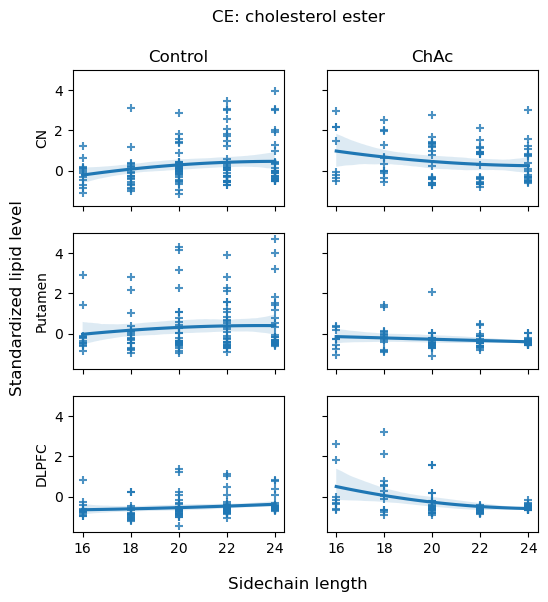

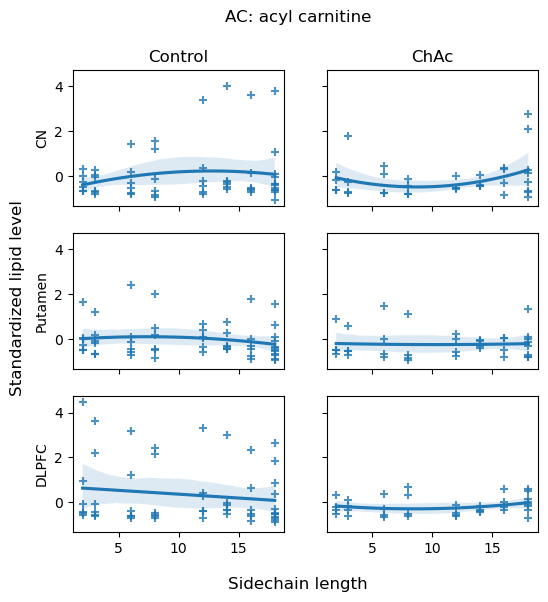

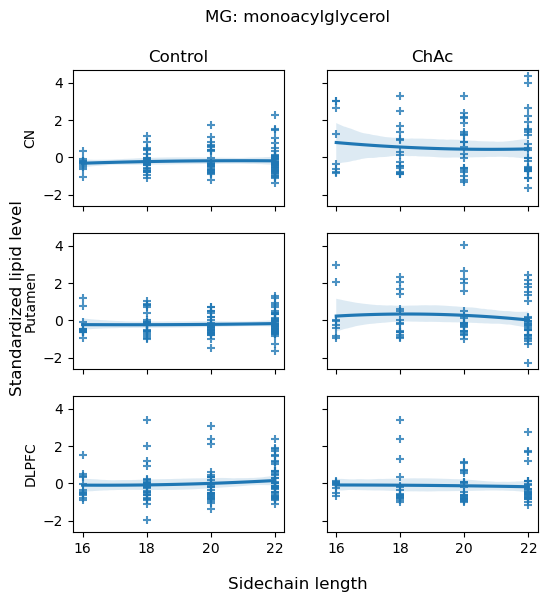

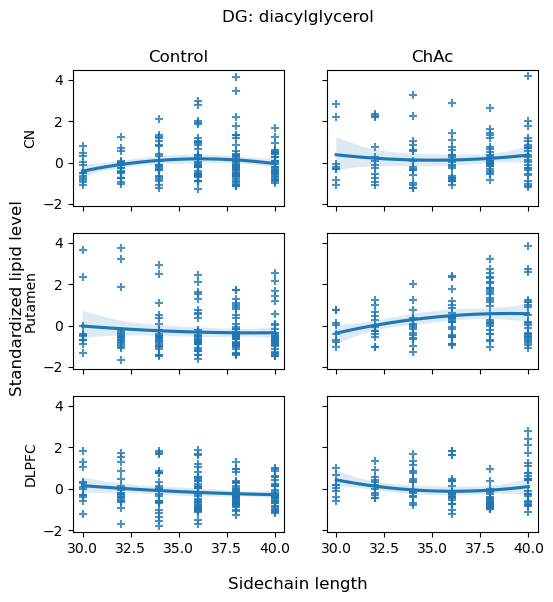

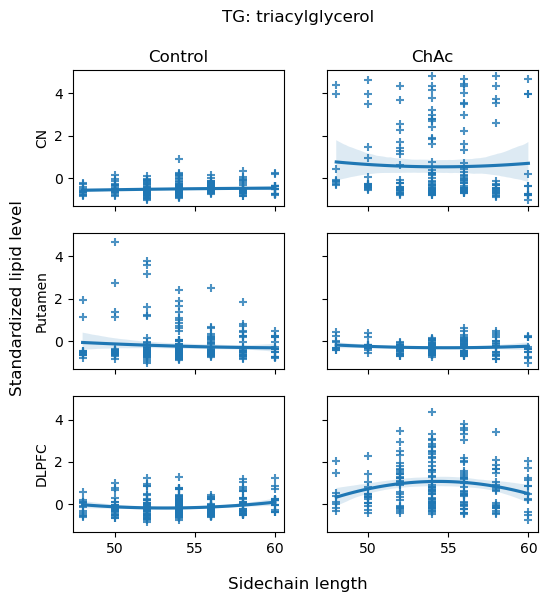

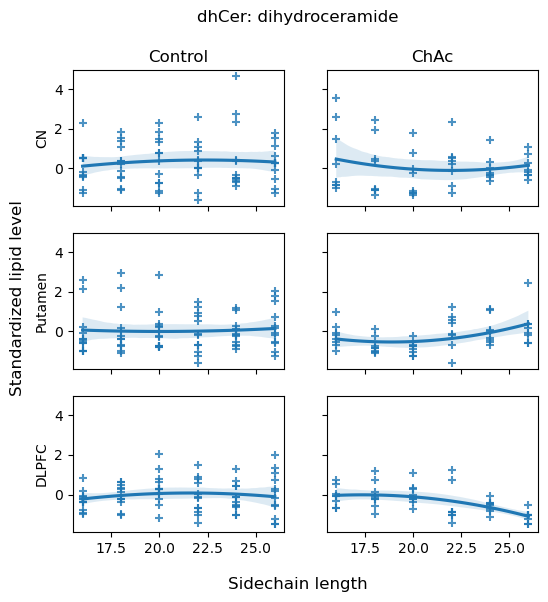

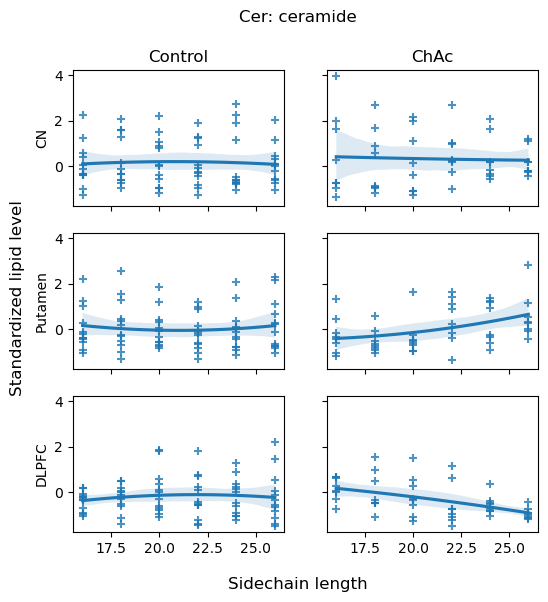

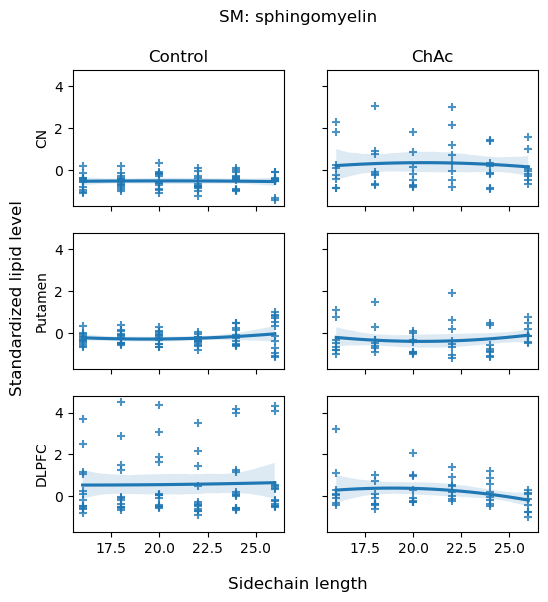

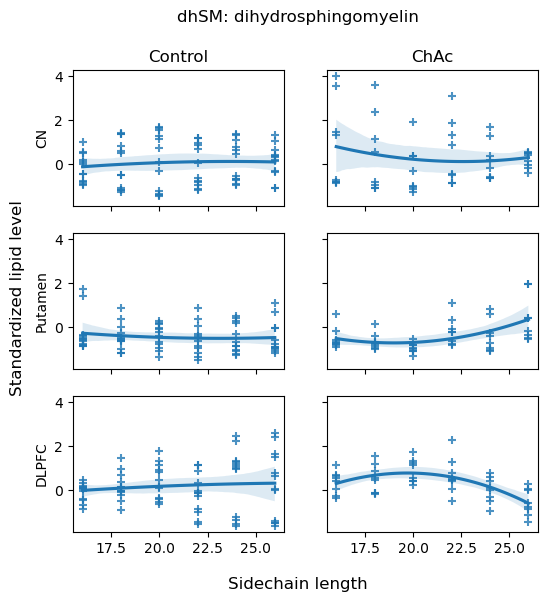

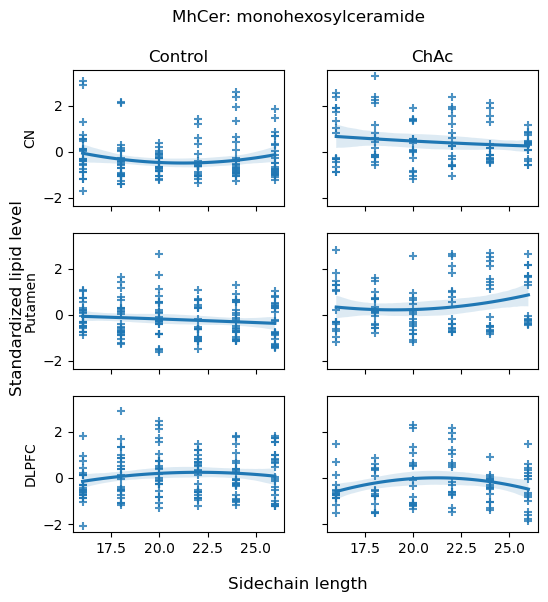

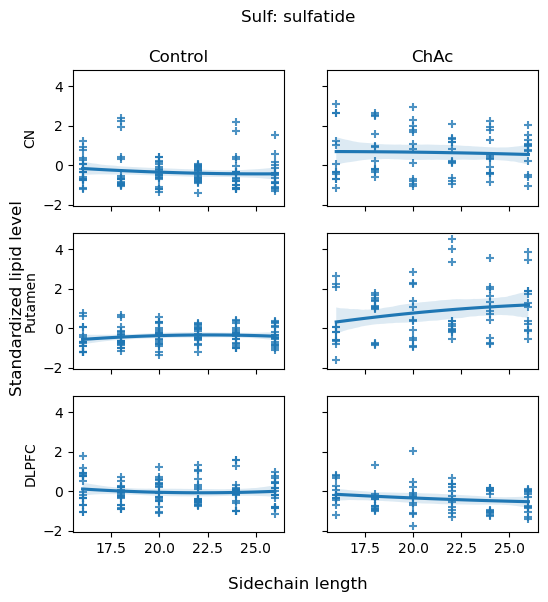

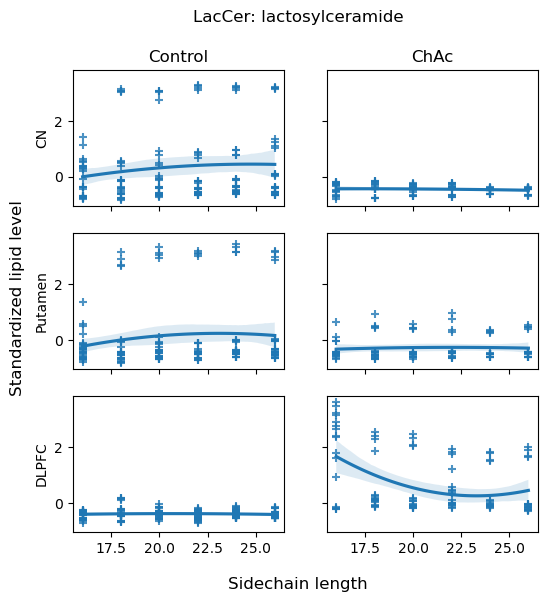

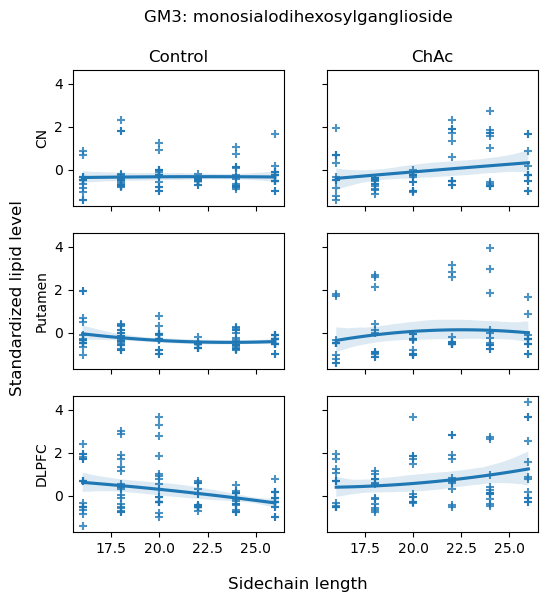

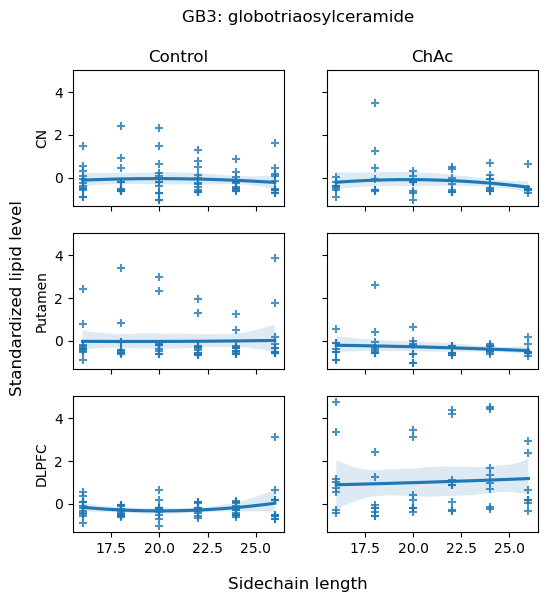

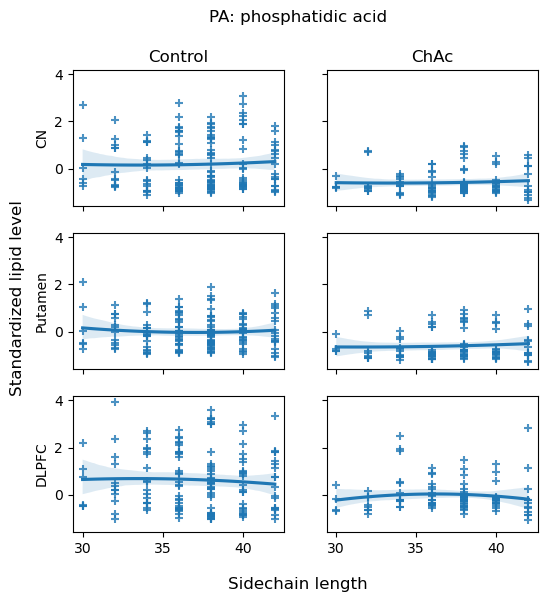

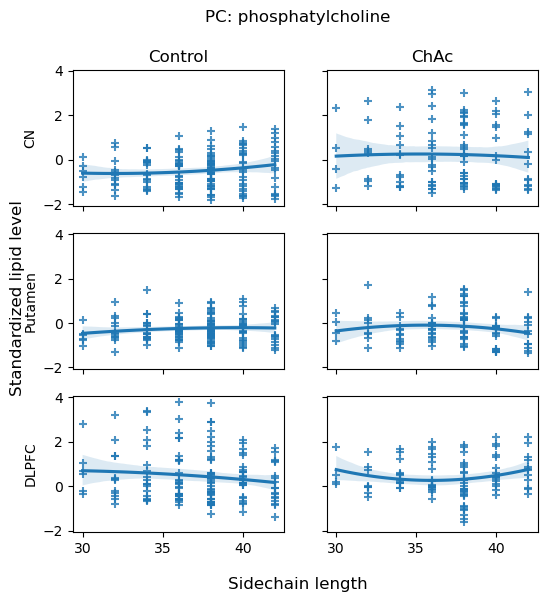

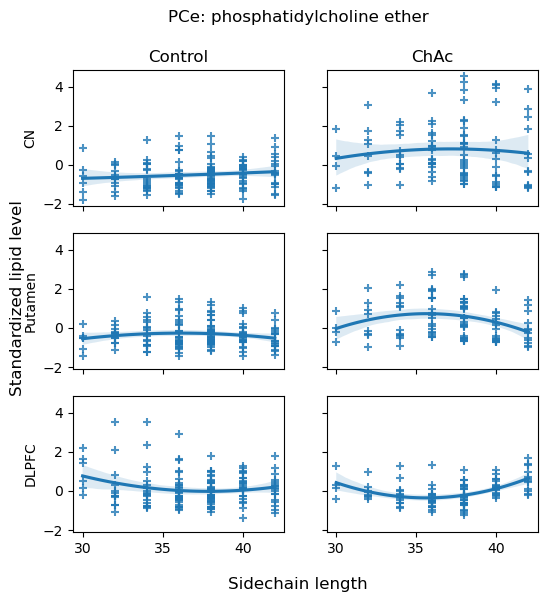

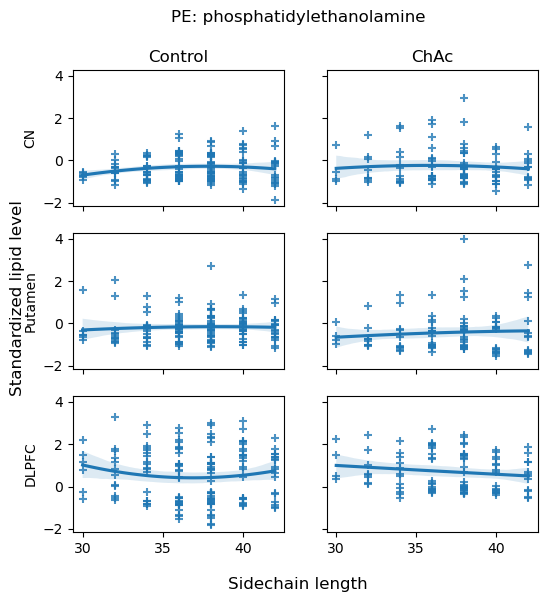

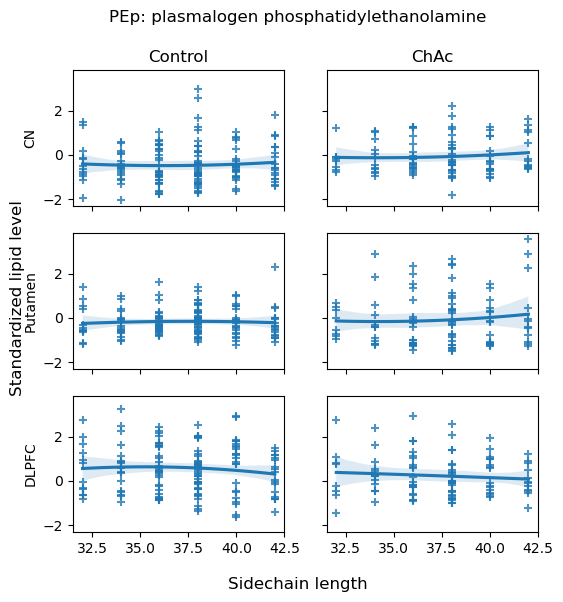

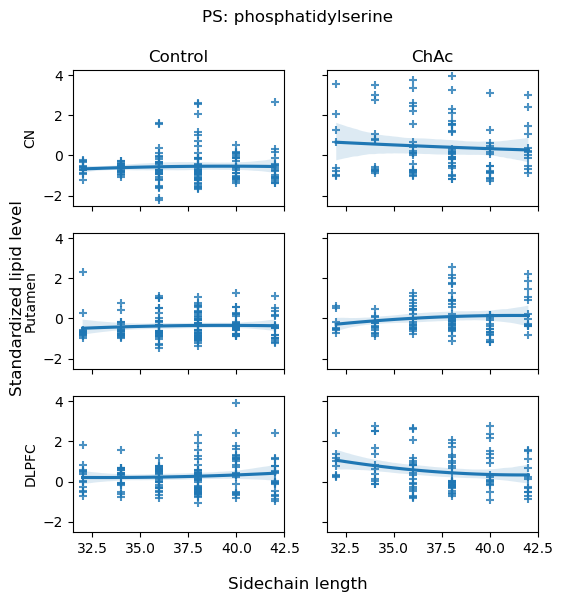

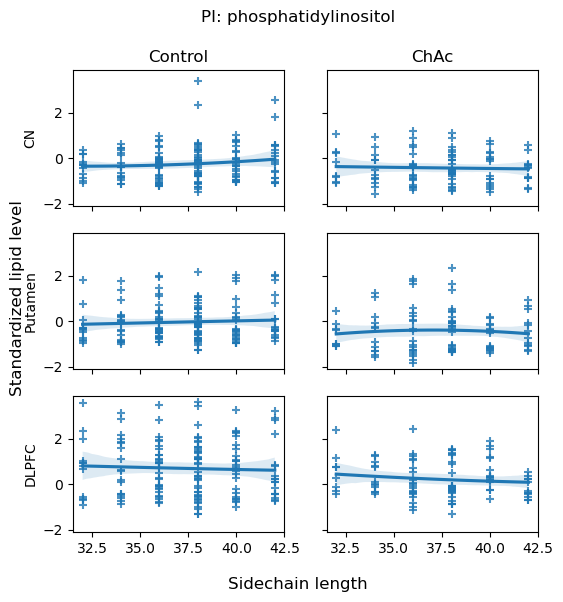

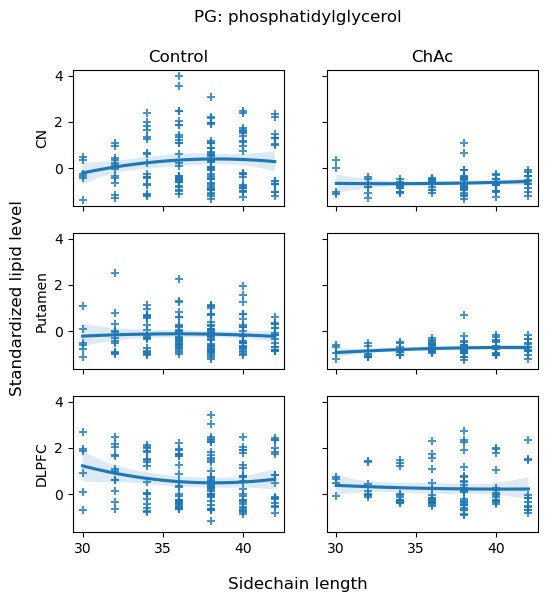

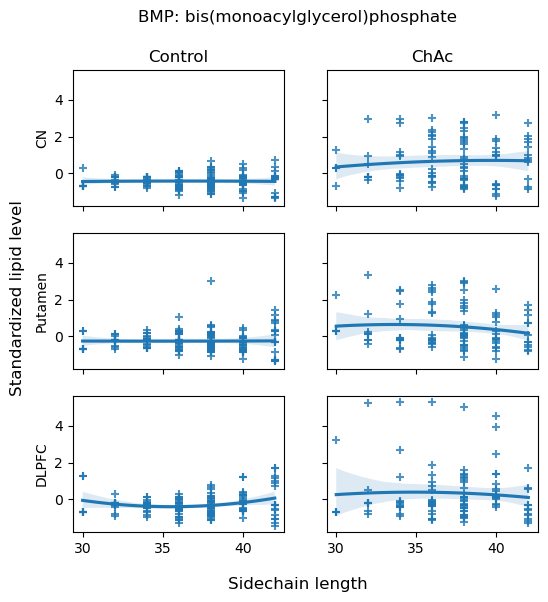

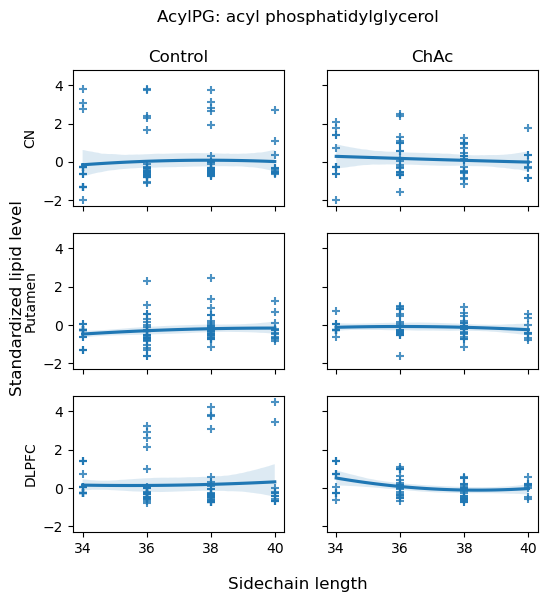

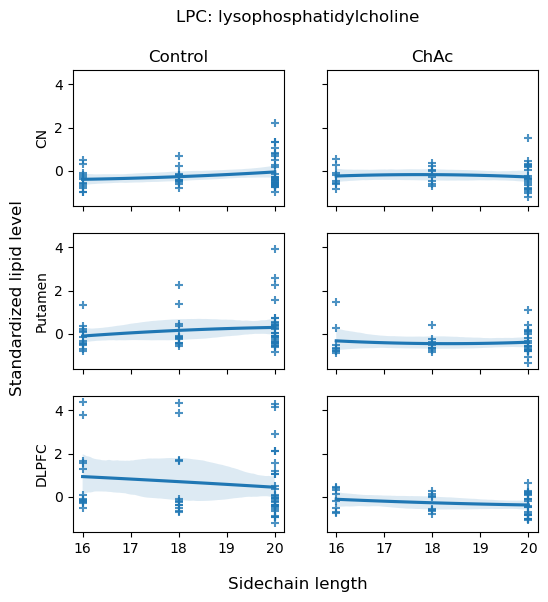

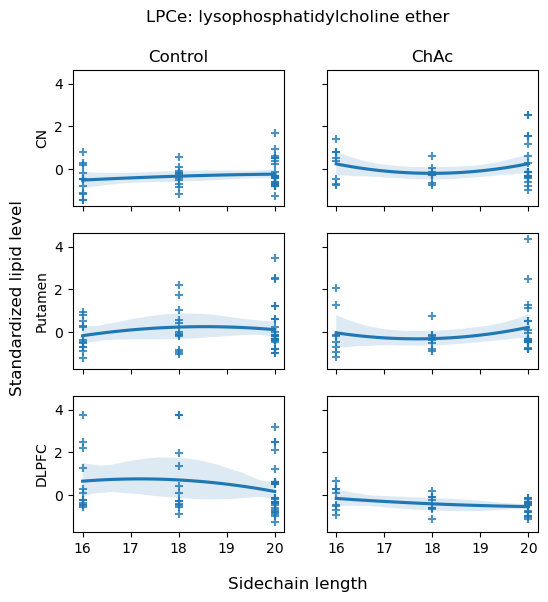

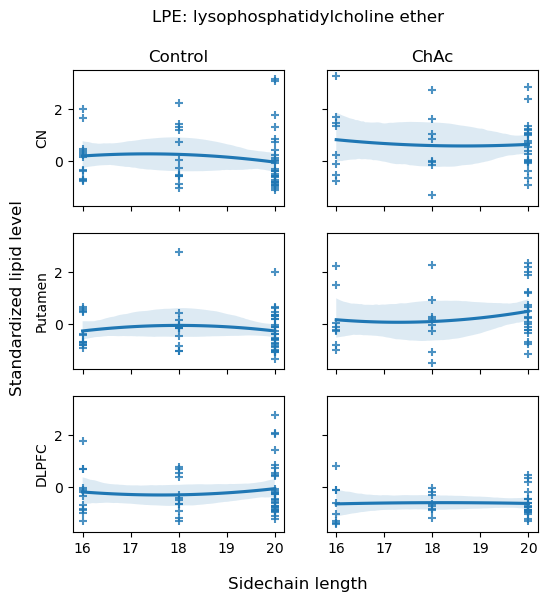

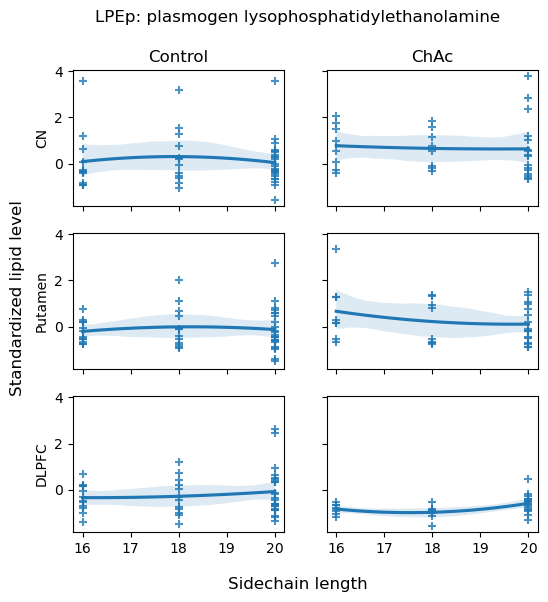

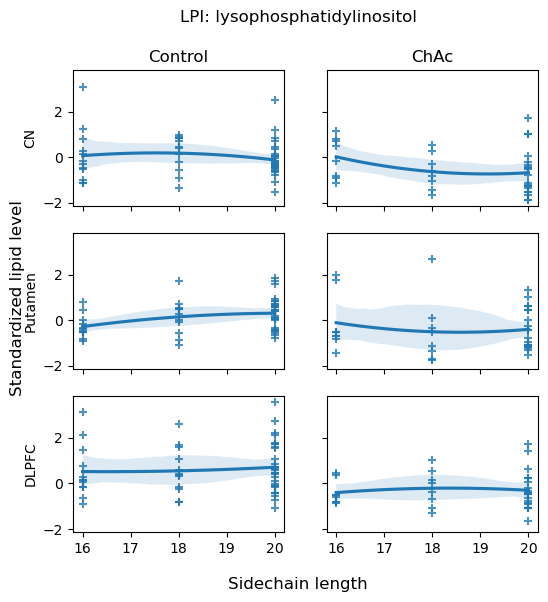

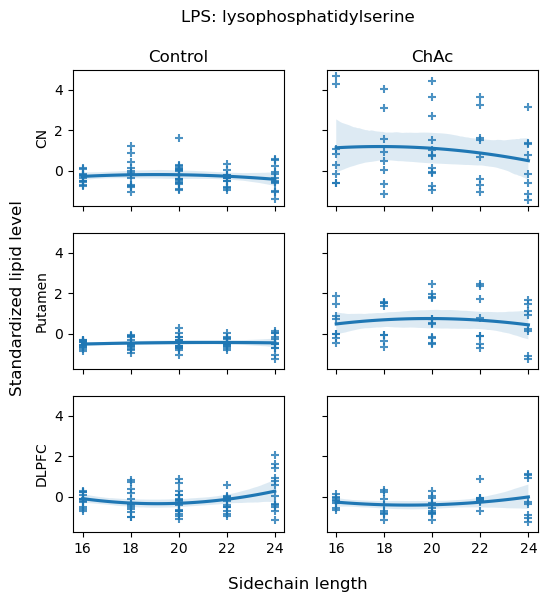

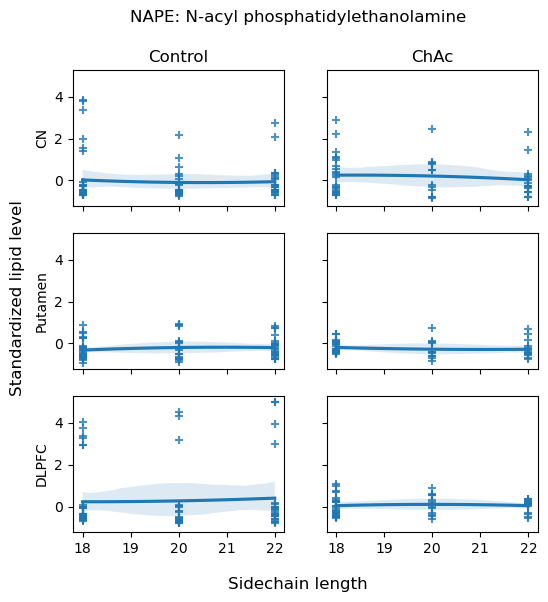

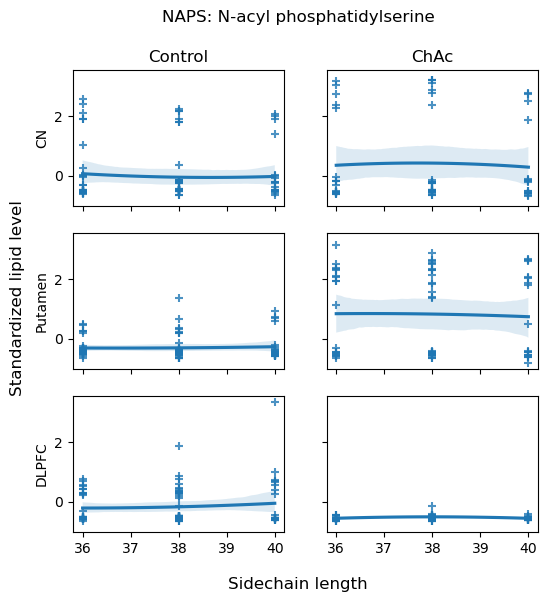

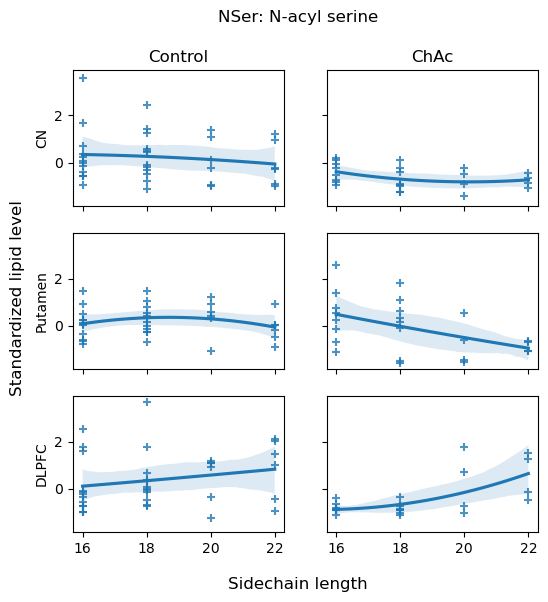

In [9]:
for group, regex in regexd.items():
    fig, ax = plot_level_sidechain(group, regex)
    attila_utils.savefig(fig, 'level-sidechain_len-' + group)

In [10]:
%connect_info

{
  "shell_port": 61028,
  "iopub_port": 61029,
  "stdin_port": 61030,
  "control_port": 61032,
  "hb_port": 61031,
  "ip": "127.0.0.1",
  "key": "4b66e4a4-80b31df4640ad4dc612fc12a",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-f4a00e17-0980-4ab8-8d57-31c4bbb9ae5f.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
